## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

## 1. Carga datos y representa la serie

In [45]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [46]:
df = pd.read_csv('data/AirPassengers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [47]:
# Ver primeras filas
print(df.head())
print(df.info())



         date  value
0  1949-01-01    112
1  1949-02-01    118
2  1949-03-01    132
3  1949-04-01    129
4  1949-05-01    121
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


In [48]:
df[['year','month','day']] = df['date'].str.split('-',expand=True)
df.head()

,date,value,year,month,day
0,1949-01-01,112,1949,01,01
1,1949-02-01,118,1949,02,01
2,1949-03-01,132,1949,03,01
3,1949-04-01,129,1949,04,01
4,1949-05-01,121,1949,05,01


In [49]:
df['Fecha'] = pd.to_datetime(df[['year', 'month', 'day']])

In [50]:
df.head()

,date,value,year,month,day,Fecha
0,1949-01-01,112,1949,01,01,1949-01-01
1,1949-02-01,118,1949,02,01,1949-02-01
2,1949-03-01,132,1949,03,01,1949-03-01
3,1949-04-01,129,1949,04,01,1949-04-01
4,1949-05-01,121,1949,05,01,1949-05-01


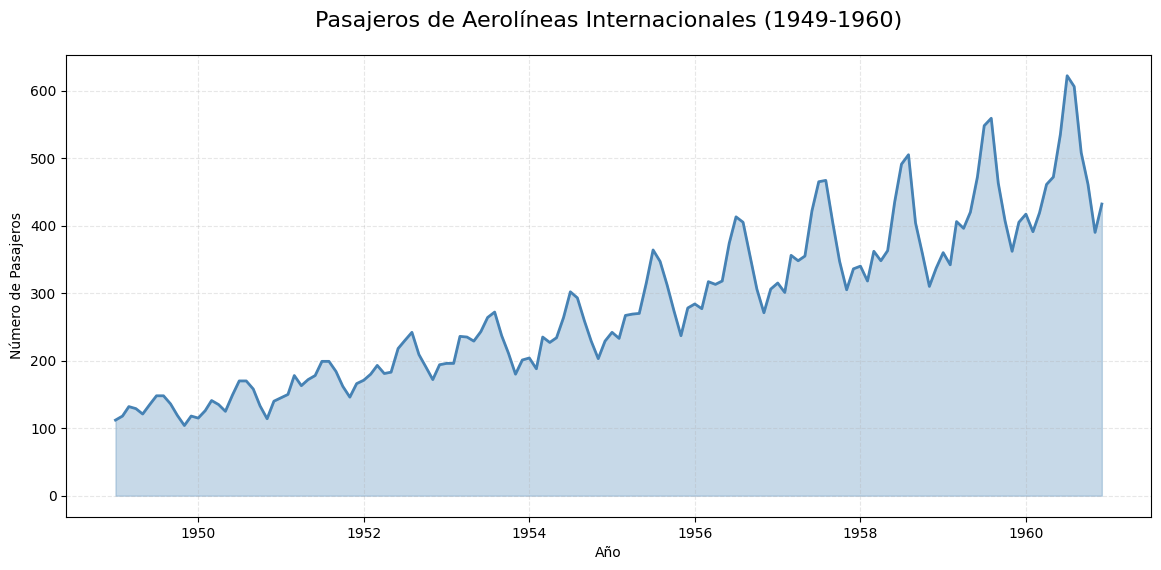

In [51]:
# 2. Convertir fecha a datetime y establecer como índice
df = df.set_index('Fecha')

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'], linewidth=2, color='steelblue')
plt.title('Pasajeros de Aerolíneas Internacionales (1949-1960)', fontsize=16, pad=20)
plt.xlabel('Año')
plt.ylabel('Número de Pasajeros')
plt.grid(True, alpha=0.3, linestyle='--')
plt.fill_between(df.index, df['value'], alpha=0.3, color='steelblue')
plt.show()

🔍 AUTOCORRELACIÓN EN LAGS CLAVE:
Lag  1 meses:   0.948  ← Muy alta correlación
Lag  2 meses:   0.876  ← Muy alta correlación
Lag  3 meses:   0.807  ← Muy alta correlación
Lag  6 meses:   0.682  ← Alta correlación
Lag 12 meses:   0.760  ← ESTACIONALIDAD ANUAL
Lag 18 meses:   0.469  ← Correlación moderada
Lag 24 meses:   0.532  ← ESTACIONALIDAD ANUAL
Lag 30 meses:   0.288  ← Baja correlación
Lag 36 meses:   0.337  ← ESTACIONALIDAD ANUAL


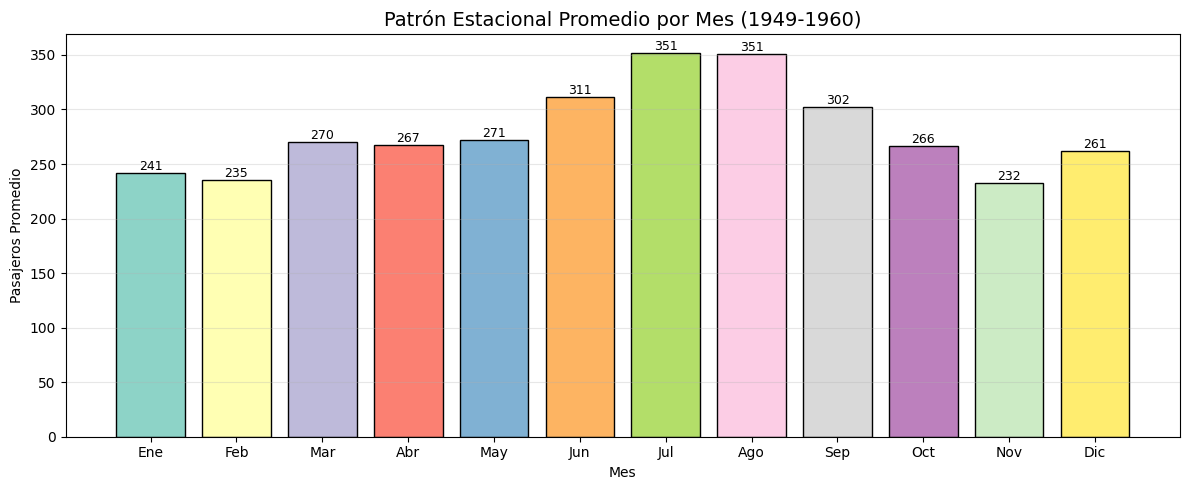

In [52]:
# 6. Calcular autocorrelaciones específicas
from statsmodels.tsa.stattools import acf

autocorr_values = acf(df['value'], nlags=36, fft=False)

print("🔍 AUTOCORRELACIÓN EN LAGS CLAVE:")
print("=" * 45)
for lag in [1, 2, 3, 6, 12, 18, 24, 30, 36]:
    valor = autocorr_values[lag]
    print(f"Lag {lag:2d} meses: {valor:7.3f} ", end="")
    
    if lag in [12, 24, 36]:
        print(" ← ESTACIONALIDAD ANUAL")
    elif valor > 0.7:
        print(" ← Muy alta correlación")
    elif valor > 0.5:
        print(" ← Alta correlación")
    elif valor > 0.3:
        print(" ← Correlación moderada")
    else:
        print(" ← Baja correlación")

# 7. Gráfico de patrones por mes (promedio mensual)
df['Month'] = df.index.month
df['Year'] = df.index.year

# Promedio por mes
monthly_avg = df.groupby('Month')['value'].mean()

plt.figure(figsize=(12, 5))
bars = plt.bar(monthly_avg.index, monthly_avg.values, 
               color=plt.cm.Set3(range(12)), edgecolor='black')

plt.title('Patrón Estacional Promedio por Mes (1949-1960)', fontsize=14)
plt.xlabel('Mes')
plt.ylabel('Pasajeros Promedio')
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                          'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 2. Crea en una gráfica la variable original con su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

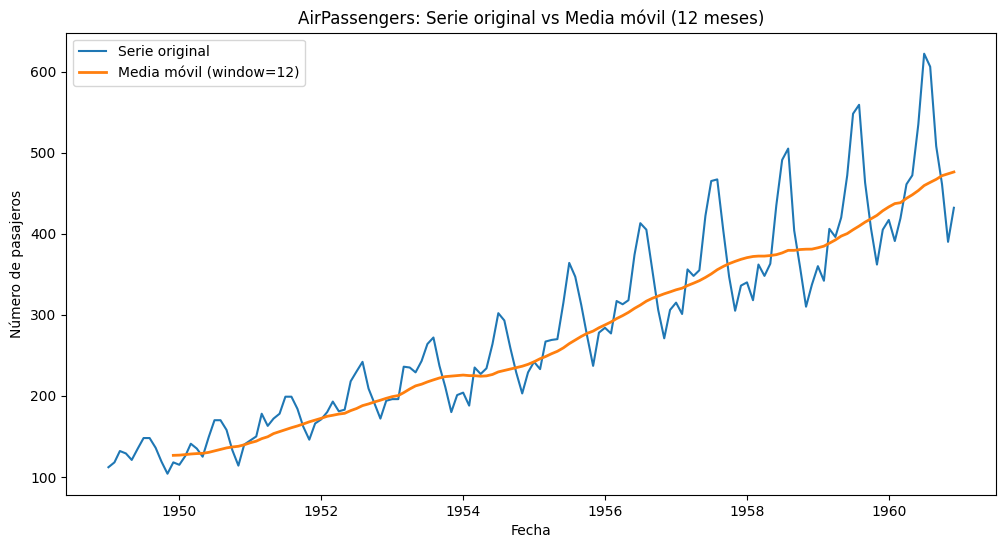

In [53]:
seasonality = 12

# Media móvil con rolling window
df['rolling_mean_12'] = df['value'].rolling(window=seasonality).mean()

# Gráfica
plt.figure(figsize=(12, 6))
plt.plot(df['value'], label='Serie original')
plt.plot(df['rolling_mean_12'], label='Media móvil (window=12)', linewidth=2)
plt.title('AirPassengers: Serie original vs Media móvil (12 meses)')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.show()

## 3. Comprueba de manera estadística si la serie es o no stationary.

In [54]:
from statsmodels.tsa.stattools import adfuller

serie = df['value']
result = adfuller(serie)

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


## 4. Aplica una transformación logarítmica

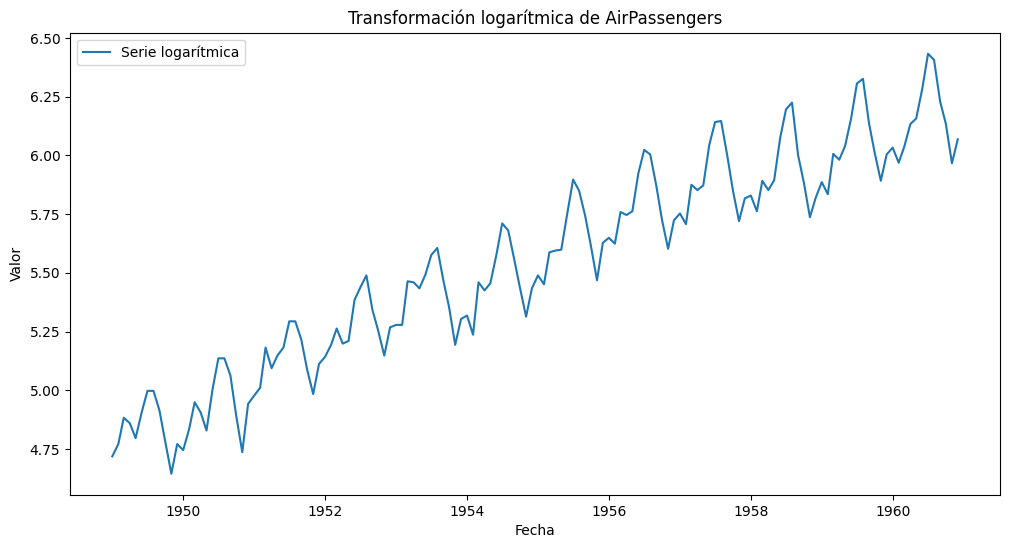

In [55]:
# Transformación logarítmica
df['log_passengers'] = np.log(df['value'])

# Gráfica comparativa
plt.figure(figsize=(12, 6))
# plt.plot(df['value'], label='Serie original')
plt.plot(df['log_passengers'], label='Serie logarítmica')
plt.title('Transformación logarítmica de AirPassengers')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

## 5. Divide en train y test. Guarda 20 muestras para test.

In [56]:
# Serie transformada (log)
log_series = np.log(df['value'])

# Número de muestras para test
test_size = 20

# División
train = log_series[:-test_size]
test = log_series[-test_size:]

print("Tamaño train:", train.shape[0])
print("Tamaño test:", test.shape[0])


Tamaño train: 124
Tamaño test: 20


## 6. Crea tu primer modelo ARIMA

In [57]:
from statsmodels.tsa.arima.model import ARIMA

# Definir el modelo (p, d, q)
model = ARIMA(train, order=(2, 1, 1))

# Entrenar el modelo
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  124
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 111.656
Date:               ju., 18 dic. 2025   AIC                           -215.312
Time:                        10:36:40   BIC                           -204.064
Sample:                    01-01-1949   HQIC                          -210.743
                         - 04-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9385      0.110      8.521      0.000       0.723       1.154
ar.L2         -0.3432      0.128     -2.687      0.007      -0.594      -0.093
ma.L1         -0.8255      0.115     -7.169      0.0

c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


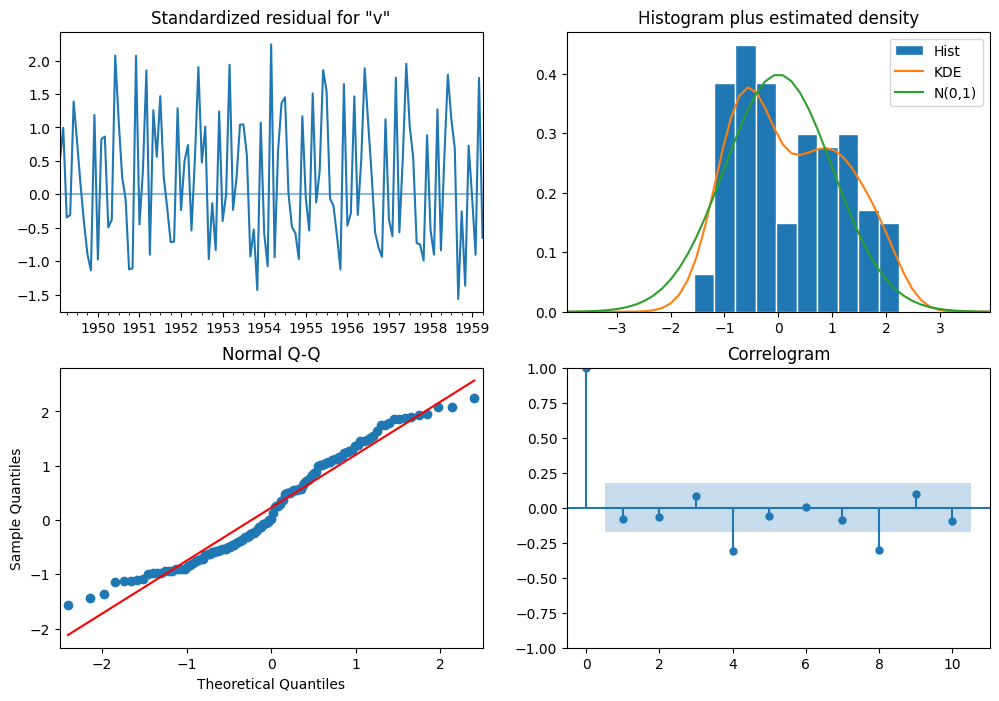

In [58]:
import matplotlib.pyplot as plt

model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

## 7. Representa en una gráfica los datos de test y tus predicciones.

In [59]:
# Número de pasos a predecir
n_test = len(test)

# Predicciones (en escala log)
pred_log = model_fit.forecast(steps=n_test)

# Volver a escala original
pred = np.exp(pred_log)
test_real = np.exp(test)

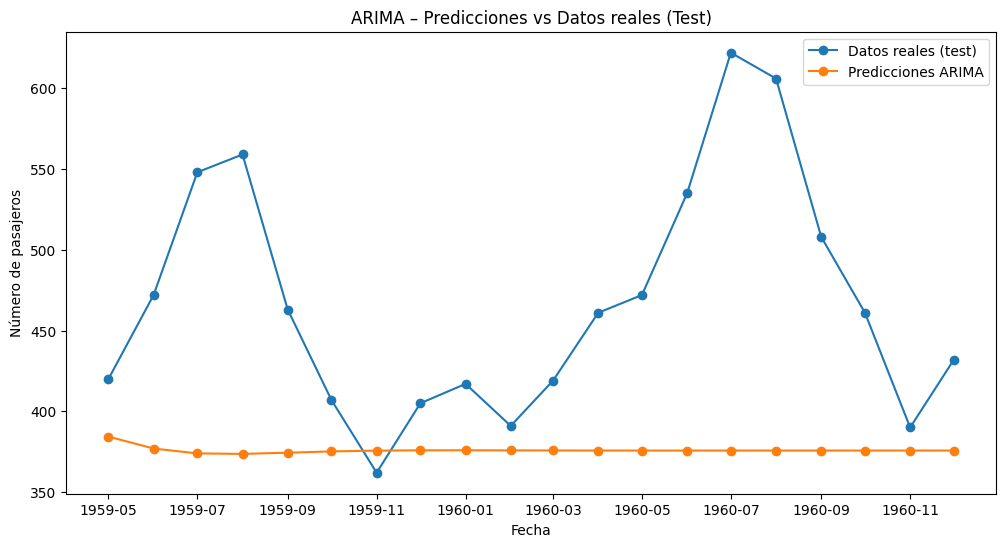

In [60]:
plt.figure(figsize=(12, 6))

plt.plot(test_real.index, test_real, label='Datos reales (test)', marker='o')
plt.plot(test_real.index, pred, label='Predicciones ARIMA', marker='o')

plt.title('ARIMA – Predicciones vs Datos reales (Test)')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.show()

## 8. Prueba otros modelos, a ver qué performance presentan.

In [61]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_arima(order, train, test):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    # Forecast
    pred_log = model_fit.forecast(steps=len(test))
    
    # Volver a escala original
    pred = np.exp(pred_log)
    test_real = np.exp(test)
    
    rmse = np.sqrt(mean_squared_error(test_real, pred))
    mae = mean_absolute_error(test_real, pred)
    
    return rmse, mae


In [64]:
models = {
    "ARIMA(1,1,1)": (1, 1, 1),
    "ARIMA(2,1,1)": (2, 1, 1),
    "ARIMA(1,1,2)": (1, 1, 2),
    "ARIMA(2,1,2)": (2, 1, 2),
    "ARIMA(0,1,1)": (0, 1, 1),
    "ARIMA(1,1,0)": (1, 1, 0)
}

results = {}

for name, order in models.items():
    rmse, mae = evaluate_arima(order, train, test)
    results[name] = {"RMSE": rmse, "MAE": mae}


c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Andre\AppData\Local\Programs\Python\Python311\L

In [65]:
import pandas as pd

results_df = pd.DataFrame(results).T
results_df.sort_values("RMSE")


,RMSE,MAE
"ARIMA(1,1,0)",102.830763,77.437509
"ARIMA(0,1,1)",106.161074,80.894795
"ARIMA(1,1,1)",106.618390,81.536155
"ARIMA(2,1,2)",115.291949,91.774473
"ARIMA(2,1,1)",116.693023,92.910854
"ARIMA(1,1,2)",117.323412,94.041327
